In [1]:
from pathlib import Path 
import matplotlib.pyplot as plt 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.measure import shannon_entropy,label,perimeter,regionprops
from skimage.filters import sobel, threshold_otsu
import pandas as pd
import numpy as np
import sys
sys.path.append('/home/benr/ACT/CW2/py')
from functions import split_data_rf,get_data,galaxy_type 
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

2025-12-03 21:42:31.669711: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 21:42:32.030461: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 21:42:33.261317: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Machine Learning for Galaxy Classification  
This project aims to test how different machine learning methods will perform on a galaxy classifaction task. 

## Qestion 1, Traditional ML method
To test a traditional ML method I will use random forest to try and predict galaxy morphology based on features of the image and pca values.
Using the Galaxy10 Decals data set, we use a sample of ~17,000 image samples to classify galaxy morphology from images. 

Radom Forest classifiers can be extremely accurate. Random forest uses the 'votes' of many decision trees to make a prediction, which makes it a good technique for finding patterns through out a dataset. The contribution from many trees means that it is not so easily confused by noise and outliers. 

In [2]:

# get the data from functions.py and print galaxy type classes
x_images,y_labels = get_data()



/home/benr/.astroNN/datasets/Galaxy10_DECals.h5 was found!


First lets show a sample of the images we are working with, to do this we will choose 8 random samples from x_images and use maplotlib to show display them. 

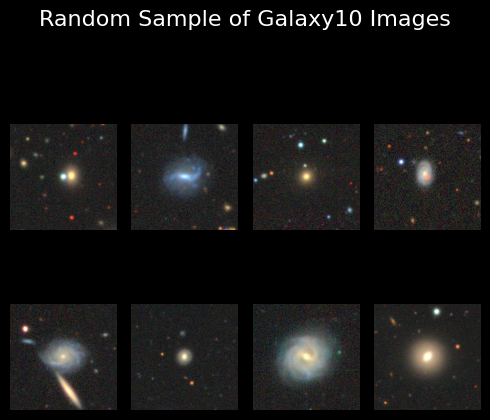

In [5]:
# choose random index 
idx = np.random.choice(len(x_images), size = 8, replace = False)
fig = plt.figure(figsize=(5,5))
plt.style.use('dark_background')
fig.patch.set_facecolor('black')
# itterate through random index's and plot images at that index 
for i,IDX in enumerate(idx):
    plt.subplot(2,4,i+1)
    img = x_images[IDX]
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("Random Sample of Galaxy10 Images", fontsize=16)
plt.tight_layout()
plt.show()



The dataset uses the following galaxy morphology catagories

Galaxy10 dataset (17736 images)
- Class 0 (1081 images): Disturbed Galaxies
- Class 1 (1853 images): Merging Galaxies
- Class 2 (2645 images): Round Smooth Galaxies
- Class 3 (2027 images): In-between Round Smooth Galaxies
- Class 4 ( 334 images): Cigar Shaped Smooth Galaxies
- Class 5 (2043 images): Barred Spiral Galaxies
- Class 6 (1829 images): Unbarred Tight Spiral Galaxies
- Class 7 (2628 images): Unbarred Loose Spiral Galaxies
- Class 8 (1423 images): Edge-on Galaxies without Bulge
- Class 9 (1873 images): Edge-on Galaxies with Bulge

see dataset documentation here for more details 
https://astronn.readthedocs.io/en/latest/galaxy10.html


# How does Random Forest Work? 
The next step will be to setup the random forest model. This is done quite easily using **RandomForestClassifier** from **sklearn.ensemble**, however it is important to understand what is actually happening when you run this model. 



The idea at the core of Random Forest is the use of many decision trees to predict outcomes based on a set of features. In this case you can see below we are implementing 1,000 trees. Each of these trees will look at a subset of randomly selected features, decide how to best split up the dataset based on these features and then 'vote' on which catagory an image belongs to.  



In [6]:
#define your random forest classifier 
rf = RandomForestClassifier(
        n_estimators=1000, # number of trees
        max_depth=None, # how many times each tree can split (No limit)
        n_jobs= 1,
        random_state= 11
        
)

The next step is to create some features for to pass into the random forest model. 

* Eccentricity - measure of how elliptical the galaxy is
                 see https://scikit-image.org/docs/0.25.x/auto_examples/segmentation/plot_regionprops.html?utm_source=chatgpt.com
                 for details.
                 
* mean sobel edge magnitude - The sobel edges is a measure of the gradient
                              at each pixel, we apply this function and then take the mean. This helps distinguish between elepitcal (smooth) galaxies and disks or spirals that will have clearer edges. 

* perimeter - perimeter measures the perimiter of shapes in a binary
              images. This will be smaller in edge on galaxies and larger in the other types. 

* Area - similar logic to perimeter, to help distigues between edge on 
         and other types. 

* asymmetry - the asymmetry is measure by rotating the image by 90 
              degrees and then taking the average of the absolute value of the difference between the two images. 
* Shannon Entropy - This is a measure of how detailed the image is, for example a solid colour image would have low entropy, but an image of an object or lanscape would have a much higher entropy. 

As well as the above features we also include mean, stadard deviation, median and maximum of the pixal values. 

for details on skimage measures see
https://scikit-image.org/docs/0.25.x/api/skimage.measure.html#

**Note** 

Traditional ML methods can be computationally expensive, especially when using large data sets like galaxy10 decals. We will therefore (for Q1 only) use greyscale images to save space on the cpu and prevent the kernel from crashing. 

In [7]:
#please note this is a lot of data and takes about 10 mins to run
# gather features of images 
gray_images = np.mean(x_images, axis=3).astype(np.float32) / 255.0 #use greyscale images 
x_features = []
for img in gray_images:
    #get binary version of image 
    th = threshold_otsu(img)
    bimg = img > th
    # eccentricity 
    lab = label(bimg)
    props = regionprops(lab)
    if len(props) > 0:
        e = props[0].eccentricity  
    else:
        e = 0.0

    edges = sobel(img)
    edg_mean = edges.mean()
     
    p = perimeter(bimg,neighborhood=6)
    A = bimg.sum() 

    rot180 = np.rot90(img, 2)
    asym = np.mean(np.abs(img - rot180))

    feats = np.array([np.mean(img), np.std(img),
                      np.max(img),np.median(img),
                      e,p,A,asym,
                      edg_mean,shannon_entropy(img)] 
                      )
    x_features.append(feats)

x_features = np.array(x_features)
print(x_features.shape) 

(17736, 10)


# Principle Componant Analysis (PCA)

Now that we have specific features of the images we will use Principle Componant Analysis (PCA) to reduce flattened image vectors to a smaller size whilst keeping the key information about the dataset. 

PCA works by calculating the covariance matrix and finding directions in which the dataset (images) vary the most. All values are then projected onto these new axes reducing the data to a chosen number of dimensions. 

see PCA guide here 
https://www.geeksforgeeks.org/maths/covariance-matrix/

In [8]:

# flatten GRAYSCALE images: [num_images, 128, 128] -> [num_images, 128*128]
N = gray_images.shape[0]
xflat = gray_images.reshape(N, -1)   # shape (N, 16384)
print("xflat shape:", xflat.shape)

xflat shape: (17736, 65536)


In [9]:
 # split into training and test sets (see functions.py) 
xtrn_FT,xtst_FT,xtrn_FL,xtst_FL,ytrn,ytst = split_data_rf(x_features,xflat,y_labels,0.1)

In [10]:
 # convert to float32 for safety
xtrn_FL = np.asarray(xtrn_FL, dtype=np.float32).reshape(len(xtrn_FL), -1)
xtst_FL = np.asarray(xtst_FL, dtype=np.float32).reshape(len(xtst_FL), -1)

# fit on 3000 samples only
pca = PCA(n_components=95)
pca.fit(xtrn_FL)

# transform all
xpca_trn = pca.transform(xtrn_FL)
xpca_tst = pca.transform(xtst_FL)

In [11]:
# join pca features with designed featers 
xtrn = np.hstack([xtrn_FT,xpca_trn]) 

In [12]:
# train the random forest model 
rf.fit(xtrn,ytrn)


,n_estimators,1000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
# join the two feature test sets 
xtst = np.hstack([xtst_FT,xpca_tst])

In [14]:
# make prediction based on test sets 
ypred = rf.predict(xtst)
print(f'accuracy score = {accuracy_score(ytst,ypred)}') 

accuracy score = 0.5479143179255919


As the results show, the random forest model only made correct predictions for half of the galaxies in the dataset. This is because the 256x256 pixel images mean that the model has a huge amount of input features; even after PCA. Each tree is trying to make decisions on all of these features which makes it difficult to find more general patterns in the image set. 

Another issue is that random forest does not have the ability to properly assess spacial features, it is not ablle to find links between certain edges and brightnesses in the same way a more sophisticated convolutional neural network might be able to. 